<a href="https://colab.research.google.com/github/aali21/Sent_analysis_fin_news/blob/main/RoBERTa_ABSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install bert-tensorflow
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 2.1 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:

import ast

json_file_path = '/content/drive/My Drive/task1_headline_ABSA_train.json'
# Read the JSON file into a Pandas DataFrame
df_headline = pd.read_json(json_file_path,orient = 'index')

df_post = pd.read_json('/content/drive/My Drive/task1_post_ABSA_train.json',orient = 'index')

display(df_headline)
df_post

# function to extract snippets from the 'info' column of the DataFrame
def get_snippets(info):
    try:
        info = info[0]['snippets']
        info = ast.literal_eval(info)
        return info[0]
    except:
        return ""

# function to extract target from the 'info' column of the DataFrame
def get_target(info):
    info = info[0]['target']
    return info

# function to extract sentiment_score from the 'info' column of the DataFrame
def get_sentiment_score(info):
    info = info[0]['sentiment_score']
    return float(info)

# function to extract aspects from the 'info' column of the DataFrame
def get_aspects(info):
    try:
        info = info[0]['aspects']
        info = ast.literal_eval(info)
        return info
    except:
        return []

# Use the above functions to add new columns to the headline DataFrame
# based on values in the 'info' column
df_headline['snippets'] = df_headline['info'].apply(get_snippets)
df_headline['target'] = df_headline['info'].apply(get_target)
df_headline['sentiment_score'] = df_headline['info'].apply(get_sentiment_score)
df_headline['aspects'] = df_headline['info'].apply(get_aspects)


# Rmeove the 'info' column from the dataframe (as its a nested column)
df_headline.drop('info', axis=1)

,sentence,info
1,Royal Mail chairman Donald Brydon set to step ...,"[{'snippets': '['set to step down']', 'target'..."
7,Stakes High for AstraZeneca Heart Drug Facing ...,"[{'snippets': '['Facing Tough Competition']', ..."
8,UPDATE 1-Dairy Crest loses a third of Morrison...,[{'snippets': '['Crest loses a third of Morris...
22,Insight hires Aviva's David Hillier for multi-...,[{'snippets': '['hires Aviva's David Hillier f...
30,Primark racks up a happy Christmas after stron...,"[{'snippets': '['after strong sales']', 'targe..."
...,...,...
1750,"Aviva, M&G suspend property funds as investors...",[{'snippets': '['M&G suspend property funds as...
1754,"UK housing market steadies after Brexit dip, P...","[{'snippets': '['housing market']', 'target': ..."
1755,BRIEF-Aviva aims to increase dividend pay-out ...,"[{'snippets': '['increase dividend pay-out']',..."
1764,Builder Persimmon hails 6% rise in house sales,"[{'snippets': '['6% rise in house sales']', 't..."


,sentence,snippets,target,sentiment_score,aspects
1,Royal Mail chairman Donald Brydon set to step ...,set to step down,Royal Mail,-0.374,[Corporate/Appointment]
7,Stakes High for AstraZeneca Heart Drug Facing ...,Facing Tough Competition,AstraZeneca,-0.240,[Corporate/Risks]
8,UPDATE 1-Dairy Crest loses a third of Morrison...,Crest loses a third of Morrisons milk contract,Morrisons,-0.161,[Corporate/Sales/Failed Contract Discussion]
22,Insight hires Aviva's David Hillier for multi-...,,Insight,0.137,[Corporate/Appointment/Executive Appointment]
30,Primark racks up a happy Christmas after stron...,after strong sales,Primark,0.704,[Corporate/Sales]
...,...,...,...,...,...
1750,"Aviva, M&G suspend property funds as investors...",M&G suspend property funds as investors panic,M&G,-0.807,[Corporate/Risks]
1754,"UK housing market steadies after Brexit dip, P...",housing market,Perssimon,0.339,[Market/Market]
1755,BRIEF-Aviva aims to increase dividend pay-out ...,increase dividend pay-out,Aviva,0.439,[Corporate/Dividend Policy]
1764,Builder Persimmon hails 6% rise in house sales,6% rise in house sales,Persimmon,0.435,[Corporate/Sales]


# Cleaning and Preprocessing

In [ ]:

import string
from bs4 import BeautifulSoup
import re
import numpy as np
import warnings
import pandas as pd
from string import punctuation
import traceback

# df_headline['aspects'] = df_headline['aspects'].apply(lambda x: [aspect.split('/')[0] for aspect in x])

# Extracting the Aspect level 2 only
def extract_second_hierarchy(aspects_list):
    second_aspects = []
    for aspect in aspects_list:
        parts = aspect.split('/')
        if len(parts) > 1:  # Check if there's a second part available
            second_aspects.append(parts[1])
        else:
            second_aspects.append(None)
    return second_aspects

df_headline['aspects'] = df_headline['aspects'].apply(extract_second_hierarchy)
# Making it into a string format (for label encoder to work properly)
df_headline['aspects'] = df_headline['aspects'].astype(str)
df_headline['aspects'] = df_headline['aspects'].str.replace("[\[\]']", "").str.strip()

# Lets pre-process the sentecnes to remove any links, tags, punctuations and numbers

class Preprocessing:

    def __init__(self):

        self.punctuation = list(string.punctuation)

        self.stop = self.punctuation

        self.table = str.maketrans({key: None for key in string.punctuation})
        self.english_punctuations = string.punctuation

    def remove_numbers(self, text):
        try:
            return re.sub(r'\b\d+(?:\.\d+)?\s+', '', text)
        except:
            return text

    def english_clean_text(self, x):

        x = BeautifulSoup(x, 'html.parser')
        x = x.get_text()
        x = x.translate(self.table)  # this will remove all punctuation including apostrophes
        x = self.remove_numbers(x)
        x = x.replace('#', '')
        x = x.replace('@', '')
        x = re.sub(r'http\S+', '', x)
        x = re.sub(r'www\S+', '', x)
        x = re.sub(r'pic.\S+', '', x)

        x = re.sub((r"^[\W]*"), "", x)
        x = re.sub((r"\s[\W]\s"), ", ", x)
        x = [i for i in x.split() if len(i) > 1]
        x = " ".join(x)
        x = [i for i in x.split() if len(i) < 16]
        x = " ".join(x)
        x = re.sub(r"[^A-Z/a-z0-9(),!?\'\`.]", " ", x)
        return x

clean_text = Preprocessing()

# remove URL's from train and test
df_headline['sentence'] = df_headline['sentence'].apply(clean_text.english_clean_text)
df_headline['snippets'] = df_headline['snippets'].apply(clean_text.english_clean_text)

# df_post['sentence'] = df_post['sentence'].apply(clean_text.english_clean_text)
# df_post['snippets'] = df_post['snippets'].apply(clean_text.english_clean_text)


df_headline.drop('info', axis=1)

<ipython-input-18-f6a26a8f0cfb>:26: FutureWarning: The default value of regex will change from True to False in a future version.
  df_headline['aspects'] = df_headline['aspects'].str.replace("[\[\]']", "").str.strip()


,sentence,snippets,target,sentiment_score,aspects
1,Royal Mail chairman Donald Brydon set to step ...,set to step down,Royal Mail,-0.374,Appointment
7,Stakes High for AstraZeneca Heart Drug Facing ...,Facing Tough Competition,AstraZeneca,-0.240,Risks
8,UPDATE 1Dairy Crest loses third of Morrisons m...,Crest loses third of Morrisons milk contract,Morrisons,-0.161,Sales
22,Insight hires Avivas David Hillier for multias...,,Insight,0.137,Appointment
30,Primark racks up happy Christmas after strong ...,after strong sales,Primark,0.704,Sales
...,...,...,...,...,...
1750,Aviva MG suspend property funds as investors p...,MG suspend property funds as investors panic,M&G,-0.807,Risks
1754,UK housing market steadies after Brexit dip Pe...,housing market,Perssimon,0.339,Market
1755,BRIEFAviva aims to increase dividend payout ra...,increase dividend payout,Aviva,0.439,Dividend Policy
1764,Builder Persimmon hails rise in house sales,rise in house sales,Persimmon,0.435,Sales


In [ ]:
df_headline[15:70]

,sentence,info,snippets,target,sentiment_score,aspects
56,FDA approves NPS drug in move validating Shire...,[{'snippets': '['validating Shire takeover dea...,validating Shire takeover deal,Shire,0.332,M&A
60,Ocwen Reaches Settlement With California Regul...,[{'snippets': '['Settlement With California Re...,Settlement With California Regulator,Ocwen,0.171,Legal
67,Morrisons faces festive sales test,"[{'snippets': '['festive sales test']', 'targe...",festive sales test,Morrisons,-0.113,Sales
69,Tesco share price dips as Blinkbox Books close...,"[{'snippets': '['share price dips']', 'target'...",share price dips,Blinkbox,-0.357,Price Action
70,Shire to buy NPS for billion to boost rare dis...,[{'snippets': '['Shire to buy NPS for $5.2 bil...,Shire to buy NPS for billion to boost rare dis...,Shire,0.235,M&A
76,AstraZenecas MedImmune Inks Licensing Deal Wit...,[{'snippets': '['Licensing Deal With Omnis Pha...,Licensing Deal With Omnis Pharmaceuticals,Omnis Pharmaceuticals,0.295,Sales
78,FDA approves Shires Vyvanse for bingeeating di...,[{'snippets': '['FDA approves Shire's Vyvanse'...,,Shire,0.291,Regulatory
82,Companies Thetrainlinecom announces arrival of...,[{'snippets': '['announces arrival of London I...,announces arrival of London IPO,Thetrainline.com,0.245,IPO
87,Breakingviews IAG can pay more for Aer Lingus,[{'snippets': '['IAG can pay more for Aer Ling...,IAG can pay more for Aer Lingus,IAG,0.120,M&A
88,Tesco share price jumps as Q3 sales top estimates,"[{'snippets': '['share price jumps']', 'target...",share price jumps,Tesco,0.719,Price Action


# **Roberta Model**

In [ ]:
!pip install transformers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from transformers import TFRobertaModel, RobertaTokenizer
import tensorflow as tf

# Split data
train_df, val_df = train_test_split(df_headline, test_size=0.2, random_state=42)

# Tokenize using roberta tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_encodings = tokenizer(train_df['sentence'].tolist(), truncation=True, padding='max_length', max_length=128)
val_encodings = tokenizer(val_df['sentence'].tolist(), truncation=True, padding='max_length', max_length=128)


# Convert aspects to numeric values
le = LabelEncoder()
le.fit(train_df['aspects'])

train_aspects = le.transform(train_df['aspects'])
val_aspects = le.transform(val_df['aspects'])


from keras.utils import to_categorical

# Converting the label encoded aspects to one-hot encoded values (as this is what the metric f1 score takes)
train_aspects_onehot = to_categorical(train_aspects, num_classes=len(le.classes_))
val_aspects_onehot = to_categorical(val_aspects, num_classes=len(le.classes_))


# Saving le (label encoder) to disk
import pickle

# Specify the filename for your le
filename = '/content/drive/My Drive/le.pkl'

# Save le to disk using pickle
with open(filename, 'wb') as f:
    pickle.dump(le, f)

# # Normalize sentiment scores
scaler = MinMaxScaler()
scaler.fit(train_df[['sentiment_score']])
train_sentiments = scaler.transform(train_df[['sentiment_score']])
val_sentiments = scaler.transform(val_df[['sentiment_score']])


# Results

In [ ]:
model.metrics_names

['loss',
 'aspect_output_loss',
 'sentiment_output_loss',
 'aspect_output_accuracy',
 'aspect_output_f1_score',
 'aspect_output_precision_aspect',
 'aspect_output_recall_aspect',
 'sentiment_output_accuracy',
 'sentiment_output_mae',
 'sentiment_output_mse',
 'sentiment_output_r_squared']

In [ ]:
model.metrics_names

['loss',
 'aspect_output_loss',
 'sentiment_output_loss',
 'aspect_output_accuracy',
 'aspect_output_multi_class_f1',
 'sentiment_output_accuracy',
 'sentiment_output_mae',
 'sentiment_output_mse']

#Results (Average)


In [ ]:
#Check other file
!pip install tensorflow-addons
import pandas as pd
from tensorflow.keras.metrics import Metric
import tensorflow_addons as tfa
from tensorflow.keras.metrics import Precision, Recall


def r_squared(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return (1 - SS_res / (SS_tot + tf.keras.backend.epsilon()))

# Define a dictionary to map metric names to their human-readable descriptions
metric_descriptions = {
    'loss': 'Overall Validation Loss',
    'aspect_output_loss': 'Aspect Prediction Loss',
    # 'sentiment_output_loss': 'Sentiment Prediction Loss',
    'aspect_output_accuracy': 'Aspect Prediction Accuracy',
    'sentiment_output_mse': 'Sentiment Prediction MSE',
    'sentiment_output_r_squared': 'Sentiment Prediction R squared',
    'aspect_output_f1_score': 'Aspect F1 Score',
    'aspect_output_precision_aspect': 'Aspect Precision',
    'aspect_output_recall_aspect': 'Aspect Recall'
}
# Initialize lists to store histories and results
all_histories = []
all_results = []


# train_dataset = tf.data.Dataset.from_tensor_slices(
#   # Using the BERT token encodings as the model's inputs.
#   (dict(train_encodings),
#   # Mapping the aspect and sentiment outputs to their corresponding model outputs.
#   {"aspect_output": train_aspects, "sentiment_output": train_sentiments.squeeze()})
# )




# Loop for 3 runs
for run in range(3):

#     # Build and compile the model [same as before]


# # Applying the following transformations to the training dataset:



  train_dataset = tf.data.Dataset.from_tensor_slices(
      (dict(train_encodings),
      {"aspect_output": train_aspects_onehot, "sentiment_output": train_sentiments.squeeze()})
  )

  val_dataset = tf.data.Dataset.from_tensor_slices(
      (dict(val_encodings),
      {"aspect_output": val_aspects_onehot, "sentiment_output": val_sentiments.squeeze()})
  ).batch(32)

    # Shuffle and batch the training dataset for each run
  train_dataset = train_dataset.shuffle(1000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)


  # train_dataset = tf.data.Dataset.from_tensor_slices(
  #     ({
  #         "input_ids": train_encodings["input_ids"],
  #         "attention_mask": train_encodings["attention_mask"],
  #         "token_type_ids": train_encodings["token_type_ids"],
  #     },
  #     {
  #         "aspect_output": train_aspects,
  #         "sentiment_output": train_sentiments.squeeze(),
  #     })
  # )

  # train_dataset = train_dataset.shuffle(1000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

  # val_dataset = tf.data.Dataset.from_tensor_slices(
  #     ({
  #         "input_ids": val_encodings["input_ids"],
  #         "attention_mask": val_encodings["attention_mask"],
  #         "token_type_ids": val_encodings["token_type_ids"],
  #     },
  #     {
  #         "aspect_output": val_aspects,
  #         "sentiment_output": val_sentiments.squeeze(),
  #     })
  # ).batch(32)


  # Model building using roBERTa
  # Load the pre-trained roberta model. This will be used as the base for our custom architecture.
  roberta_model = TFRobertaModel.from_pretrained('roberta-base')

  # Define the input layer for the token IDs, token type IDs and attention masks
  input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="input_ids")
  attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="attention_mask")

  # Pass the defined inputs through the BERT model. The model returns a tuple where the first
  # element (indexed by [0]) is the sequence of hidden-states for each token in our input.
  sequence_output = roberta_model([input_ids, attention_mask])[0]


  #input_layer = tf.keras.layers.Input(shape=(128,), dtype=tf.int32)
  #sequence_output = bert_model(input_layer)[0]
  pooled_output = sequence_output[:, 0, :]

  # Aspect prediction layer
  aspect_output = tf.keras.layers.Dense(len(le.classes_), activation='softmax', name='aspect_output')(pooled_output)
  # Sentiment prediction layer
  sentiment_output = tf.keras.layers.Dense(1, activation='sigmoid', name='sentiment_output')(pooled_output)

  #model = tf.keras.Model(inputs=input_layer, outputs=[aspect_output, sentiment_output])
  model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[aspect_output, sentiment_output])

  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
  model.compile(optimizer=optimizer,
                loss={'aspect_output': 'categorical_crossentropy', 'sentiment_output': 'mean_squared_error'},
                metrics={'aspect_output': ['accuracy', tfa.metrics.F1Score(num_classes=len(le.classes_), average='macro'),
                                          Precision(name='precision_aspect'),
                                          Recall(name='recall_aspect')],
                        'sentiment_output': ['accuracy','mae','mse',r_squared]})

    # Training
  history = model.fit(train_dataset, epochs=3, validation_data=val_dataset, verbose=1)
  all_histories.append(history.history)

  # Evaluating
  results = model.evaluate(val_dataset)

  # Convert the results into a dictionary with metric names as keys for this run
  results_dict = {
        metric_descriptions[metric_name]: metric_value
        for metric_name, metric_value in zip(model.metrics_names, results)
        if metric_name in metric_descriptions
    }

  all_results.append(results_dict)


# Save the entire model to a HDF5 file
model.save("/content/drive/My Drive/my_roberta_model.h5")

# Convert all_results (list of dicts) into a DataFrame
all_results_df = pd.DataFrame(all_results)

# Calculate average of each metric over the 3 runs
average_results = all_results_df.mean().to_dict()

# Convert the average results dictionary to a DataFrame
results_df = pd.DataFrame.from_dict(average_results, orient='index', columns=['Average (3 runs)'])
results_df

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'roberta.embeddings.position_ids', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Epoch 1/3


11/11 [==============================] - 54s 771ms/step - loss: 3.1144 - aspect_output_loss: 3.0646 - sentiment_output_loss: 0.0498 - aspect_output_accuracy: 0.1437 - aspect_output_f1_score: 0.0340 - aspect_output_precision_aspect: 0.0000e+00 - aspect_output_recall_aspect: 0.0000e+00 - sentiment_output_accuracy: 0.0000e+00 - sentiment_output_mae: 0.1829 - sentiment_output_mse: 0.0498 - sentiment_output_r_squared: -0.3202 - val_loss: 2.6107 - val_aspect_output_loss: 2.5647 - val_sentiment_output_loss: 0.0460 - val_aspect_output_accuracy: 0.3636 - val_aspect_output_f1_score: 0.0695 - val_aspect_output_precision_aspect: 0.0000e+00 - val_aspect_output_recall_aspect: 0.0000e+00 - val_sentiment_output_accuracy: 0.0000e+00 - val_sentiment_output_mae: 0.1847 - val_sentiment_output_mse: 0.0460 - val_sentiment_output_r_squared: -0.1020
Epoch 2/3
11/11 [==============================] - 4s 353ms/step - loss: 2.1944 - aspect_output_loss: 2.1487 - sentiment_output_loss: 0.0457 - aspect_output_accur

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'roberta.embeddings.position_ids', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Epoch 1/3


11/11 [==============================] - 55s 793ms/step - loss: 3.1333 - aspect_output_loss: 3.0874 - sentiment_output_loss: 0.0460 - aspect_output_accuracy: 0.1351 - aspect_output_f1_score: 0.0336 - aspect_output_precision_aspect: 0.0000e+00 - aspect_output_recall_aspect: 0.0000e+00 - sentiment_output_accuracy: 0.0000e+00 - sentiment_output_mae: 0.1730 - sentiment_output_mse: 0.0460 - sentiment_output_r_squared: -0.2305 - val_loss: 2.6462 - val_aspect_output_loss: 2.5938 - val_sentiment_output_loss: 0.0524 - val_aspect_output_accuracy: 0.3864 - val_aspect_output_f1_score: 0.0793 - val_aspect_output_precision_aspect: 0.0000e+00 - val_aspect_output_recall_aspect: 0.0000e+00 - val_sentiment_output_accuracy: 0.0000e+00 - val_sentiment_output_mae: 0.1756 - val_sentiment_output_mse: 0.0524 - val_sentiment_output_r_squared: -0.1861
Epoch 2/3
11/11 [==============================] - 4s 339ms/step - loss: 2.3300 - aspect_output_loss: 2.2830 - sentiment_output_loss: 0.0470 - aspect_output_accur

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'roberta.embeddings.position_ids', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Epoch 1/3


11/11 [==============================] - 54s 781ms/step - loss: 3.1320 - aspect_output_loss: 3.0798 - sentiment_output_loss: 0.0521 - aspect_output_accuracy: 0.1264 - aspect_output_f1_score: 0.0345 - aspect_output_precision_aspect: 0.0000e+00 - aspect_output_recall_aspect: 0.0000e+00 - sentiment_output_accuracy: 0.0029 - sentiment_output_mae: 0.1891 - sentiment_output_mse: 0.0521 - sentiment_output_r_squared: -0.4718 - val_loss: 2.9037 - val_aspect_output_loss: 2.8514 - val_sentiment_output_loss: 0.0523 - val_aspect_output_accuracy: 0.1818 - val_aspect_output_f1_score: 0.0553 - val_aspect_output_precision_aspect: 1.0000 - val_aspect_output_recall_aspect: 0.0114 - val_sentiment_output_accuracy: 0.0000e+00 - val_sentiment_output_mae: 0.2020 - val_sentiment_output_mse: 0.0523 - val_sentiment_output_r_squared: -0.2351
Epoch 2/3
11/11 [==============================] - 4s 349ms/step - loss: 2.3569 - aspect_output_loss: 2.3123 - sentiment_output_loss: 0.0446 - aspect_output_accuracy: 0.3879 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


,Average (3 runs)
Overall Validation Loss,1.846339
Aspect Prediction Loss,1.802776
Aspect Prediction Accuracy,0.518939
Aspect F1 Score,0.252535
Aspect Precision,0.733550
Aspect Recall,0.409091
Sentiment Prediction MSE,0.043563
Sentiment Prediction R squared,-0.017888


In [ ]:
# Obtain predicted and true labels for plotting confusion matrix

# Get model predictions for the validation dataset
val_predictions = model.predict(val_dataset)

# For aspect_output, get the class with the highest probability as the predicted label
predicted_aspects = np.argmax(val_predictions[0], axis=1)

# Convert one-hot encoded true labels back to label-encoded format
true_aspects = np.argmax(val_aspects_onehot, axis=1)


3/3 [==============================] - 3s 92ms/step


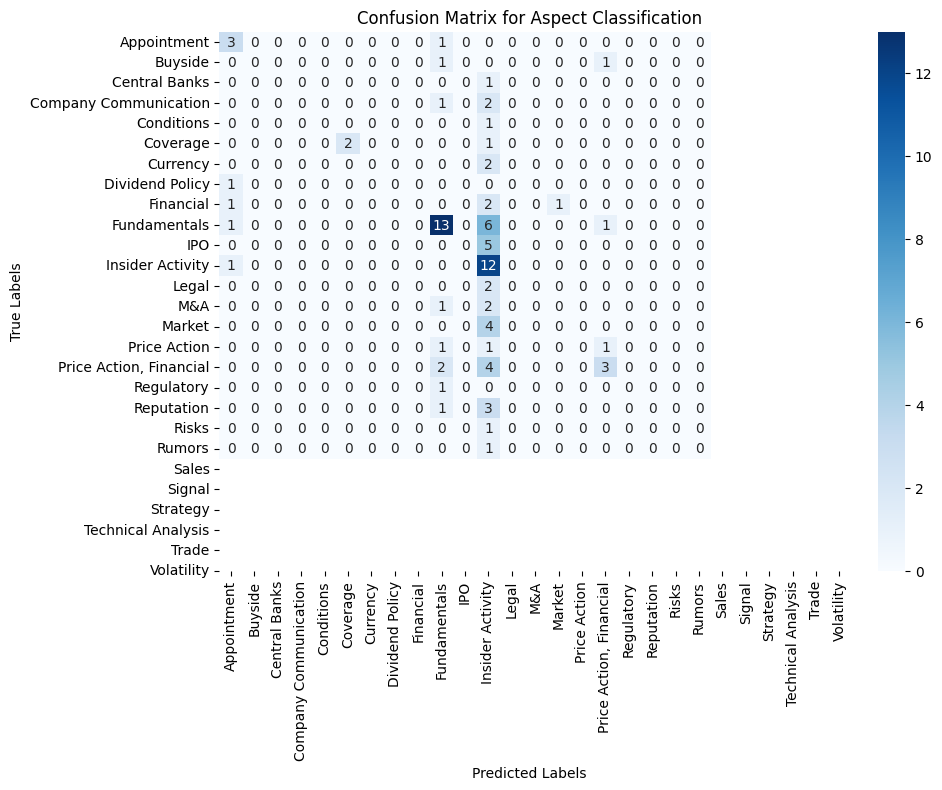

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(true_aspects, predicted_aspects)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Aspect Classification')
plt.show()


In [ ]:
import numpy as np
print(np.array(train_encodings["input_ids"]).shape)


(348, 128)


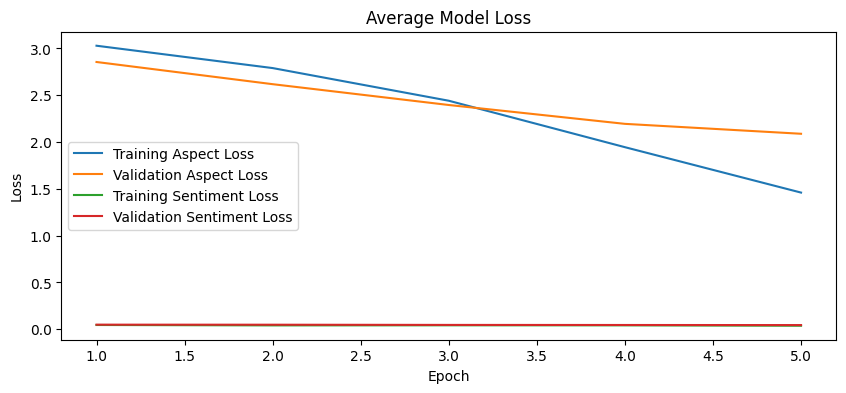

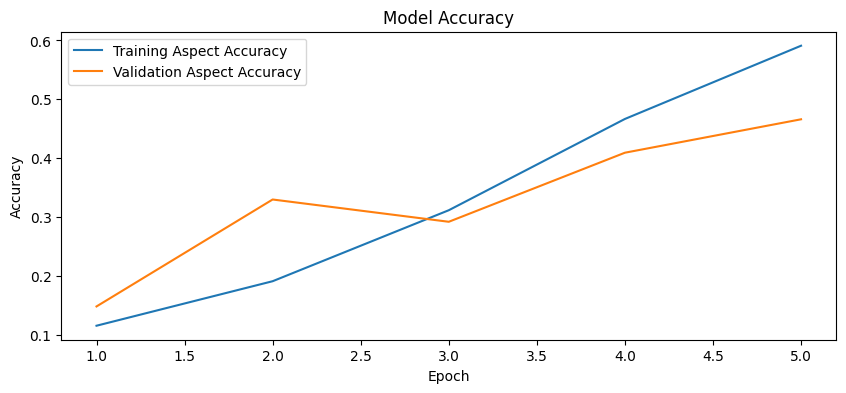

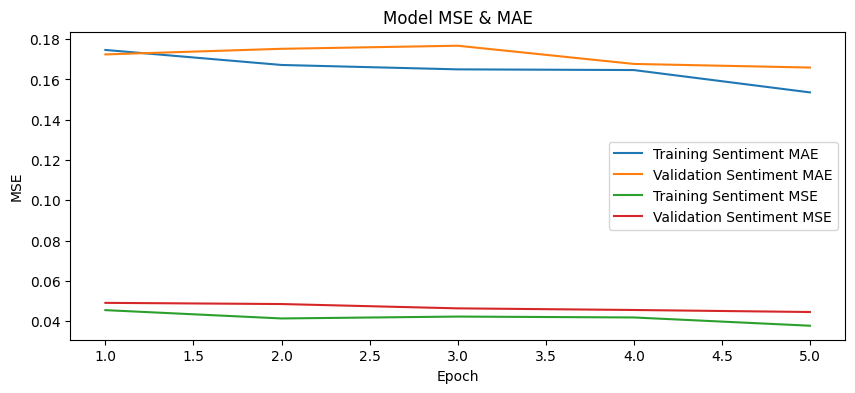

In [ ]:
# Plotting results
import numpy as np
import matplotlib.pyplot as plt

# Averaging the histories
average_history = {}
num_runs = len(all_histories)

for key in all_histories[0]:
    # Sum the values for each key from all histories
    summed = np.sum([history[key] for history in all_histories], axis=0)
    average_history[key] = summed / num_runs

    ## then carry on


epochs = range(1, len(average_history['aspect_output_loss']) + 1)
# Plotting
plt.figure(figsize=(10, 4))

plt.plot(epochs,average_history['aspect_output_loss'], label='Training Aspect Loss')
plt.plot(epochs,average_history['val_aspect_output_loss'], label='Validation Aspect Loss')
plt.plot(epochs,average_history['sentiment_output_loss'], label='Training Sentiment Loss')
plt.plot(epochs,average_history['val_sentiment_output_loss'], label='Validation Sentiment Loss')
plt.title('Average Model Loss'.format(num_runs))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


# Plotting accuracy (or other metrics if needed)
plt.figure(figsize=(10, 4))
plt.plot(epochs, average_history['aspect_output_accuracy'], label='Training Aspect Accuracy')
plt.plot(epochs, average_history['val_aspect_output_accuracy'], label='Validation Aspect Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plotting MAE & MSE (or other metrics if needed)
plt.figure(figsize=(10, 4))
plt.plot(epochs, average_history['sentiment_output_mae'], label='Training Sentiment MAE')
plt.plot(epochs, average_history['val_sentiment_output_mae'], label='Validation Sentiment MAE')
plt.plot(epochs, average_history['sentiment_output_mse'], label='Training Sentiment MSE')
plt.plot(epochs, average_history['val_sentiment_output_mse'], label='Validation Sentiment MSE')
plt.title('Model MSE & MAE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
average_history

{'loss': array([3.32302856, 2.94514775, 2.69292013]),
 'aspect_output_loss': array([3.10980813, 2.84850971, 2.62071315]),
 'sentiment_output_loss': array([0.21322026, 0.09663791, 0.07220692]),
 'aspect_output_accuracy': array([0.10057471, 0.15613027, 0.22988506]),
 'sentiment_output_accuracy': array([0.00191571, 0.00191571, 0.00383142]),
 'sentiment_output_mae': array([0.40142011, 0.25076325, 0.21397862]),
 'sentiment_output_mse': array([0.21322026, 0.09663791, 0.07220692]),
 'val_loss': array([3.07913693, 2.83326848, 2.73377339]),
 'val_aspect_output_loss': array([2.93643347, 2.76784921, 2.65603598]),
 'val_sentiment_output_loss': array([0.14270358, 0.06541926, 0.07773751]),
 'val_aspect_output_accuracy': array([0.15909091, 0.22348485, 0.24242424]),
 'val_sentiment_output_accuracy': array([0., 0., 0.]),
 'val_sentiment_output_mae': array([0.3190682 , 0.20802812, 0.21040147]),
 'val_sentiment_output_mse': array([0.14270358, 0.06541926, 0.07773751])}